In [1]:
from read_json import *
from spectrum_integrate import *
from plots import *
from source_filter import *
from variability_estimator import *

In [2]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table

In [3]:
## import

path_4lac_dr3_catalog = '../4LAC_catalog_generator_v3/resulting_catalogs/agn_pop_4lac_dr3.ecsv'
table_agn_pop_4lac_dr3 = Table.read(path_4lac_dr3_catalog, format='ascii.ecsv')
df_agn_pop_4lac_dr3 = table_agn_pop_4lac_dr3.to_pandas()

df_agn_pop_4lac_dr3.head()

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000
0,J0001.2+4741,0.3126,47.685902,-inf,PowerLaw,2420.575195,2.156031e-14,2.271696,2.196550e-14,2.254081,0.012156,bcu,ISP,25.313953,0.675882,0.312850,1.259796e-10,2.877197e-11
1,J0001.2-0747,0.3151,-7.797100,-inf,PowerLaw,1721.603882,2.656894e-13,2.116692,2.842831e-13,2.078927,0.051182,bll,LSP,46.780693,0.406565,0.111870,7.471219e-10,5.041939e-11
2,J0001.4-0010,0.3717,-0.169900,0.461516,PowerLaw,4307.082520,6.067356e-15,1.939160,6.488817e-15,1.661223,0.132438,bll,LSP,9.272764,0.000000,10.000000,1.082246e-10,2.914440e-11
3,J0001.5+2113,0.3815,21.218300,1.106000,LogParabola,329.773743,4.683598e-11,2.654060,5.371562e-11,2.514159,0.159319,fsrq,ISP,1910.935791,0.996138,0.213478,1.347354e-09,6.172809e-11
4,J0001.6-4156,0.4165,-41.942501,-inf,PowerLaw,4047.030029,1.881541e-14,1.775175,2.131597e-14,1.693865,0.072754,bcu,HSP,26.393343,0.490977,0.175782,2.821817e-10,3.090882e-11


In [4]:
## saving our changes in a separate dataframe

df_4lac_luana_dr3 = df_agn_pop_4lac_dr3.copy()

In [5]:
df_4lac_luana_dr3 = df_4lac_luana_dr3.drop(df_4lac_luana_dr3.columns[5:11], axis=1)
df_4lac_luana_dr3 = df_4lac_luana_dr3.drop(columns=['RAJ2000', 'DEJ2000', 'Redshift', 'Flux1000', 'Unc_Flux1000'])

In [6]:
## adding spectrum flux calculations

spectrum_flux_values = []
spectrum_flux_Flux1000comparison = []

for index, row in df_4lac_luana_dr3.iterrows():
    source_name = row['Source_Name']
    
    ## integrate from 1-100 GeV
    spectrum_flux_test, diff_flux_test, spec_type_test = integrate_spectrum_flux(source_name, df_agn_pop_4lac_dr3, 1, 100)
    spectrum_flux_Flux1000comparison.append(spectrum_flux_test)
    
    ## integrate from 0.1-100 GeV
    spectrum_flux, diff_flux, spec_type = integrate_spectrum_flux(source_name, df_agn_pop_4lac_dr3, 0.1, 100)
    spectrum_flux_values.append(spectrum_flux)

df_4lac_luana_dr3['Spectrum_Flux_Estimated'] = spectrum_flux_values

/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/spectrum_integrate.py:71: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  flux_from_spectrum = integrate.quad(lambda x: K * ((x/E_0)**(- alpha - beta * np.log(x/E_0))),


In [7]:
## getting a list of the downloaded sources

folder_path = '../4LAC_lightcurve_downloader_v3/resulting_catalogs/input_lightcurve_downloads_v3/fixed_indexed_lightcurves/3days_ts1_fixedindex_lightcurves'

## glob to get all .json files in the folder
json_files = glob.glob(os.path.join(folder_path, '*.json'))
json_file_names = [os.path.basename(file)[5:17] for file in json_files]

len(json_file_names)

1429

In [8]:
## creating a df for the downloaded sources

df_filtered_4lac_luana_dr3 = df_4lac_luana_dr3[df_4lac_luana_dr3['Source_Name'].isin(json_file_names)].copy()
df_filtered_4lac_luana_dr3.reset_index(drop=True, inplace=True)

print(len(df_filtered_4lac_luana_dr3))

1429


In [9]:
json_source_names = df_filtered_4lac_luana_dr3['Source_Name'].tolist()

len(json_source_names)

1429

In [10]:
# ## Testing

# file_name = f'4FGL+J0010.6+2043.json'
# # file_name = f'4FGL+J0726.4-4727.json'

# source_data = Read_json_file(file_name, '3-days', 'fixed')
# source_df = source_data.dataframe
# source_dict = source_data.dictionary

# filtered_df, median_df, inputed_df, n_unconstrained = check_and_fill_bins(source_df)
    

## Monthly NEX estimates

In [11]:
#### open light curve files & FILTER
## input invalid bins with flux = 0 and flux_error = flux[previous_bin]

## monthly

source_names_monthly = []
UL_bright_ratio_monthly = []

## case zero
nExcess_monthly_zero = []
unc_nExcess_monthly_zero = []
fvar_monthly_zero = []
unc_fvar_monthly_zero = []


for source_name in json_source_names:
    file_name = f'4FGL+{source_name}.json'
    source_data = Read_json_file(file_name, 'monthly', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df, median_df, inputed_df, n_unconstrained = check_and_fill_bins(source_df)
    
    ## UL check
    if len(median_df['flux'].dropna()) != 0:
        bright_ratio = n_unconstrained / len(median_df['flux'].dropna())
    else:
        bright_ratio = 10.0
        
    UL_bright_ratio_monthly.append(bright_ratio)
    
    variability = Estimate_variability(inputed_df)
    sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()

    source_names_monthly.append(source_name)

    nExcess_monthly_zero.append(sigma_nxs)
    unc_nExcess_monthly_zero.append(err_sigma_nxs)
    fvar_monthly_zero.append(fvar)
    unc_fvar_monthly_zero.append(err_fvar)
    
df_variability_monthly_zero = pd.DataFrame(list(zip(source_names_monthly, UL_bright_ratio_monthly,
                                                     nExcess_monthly_zero, unc_nExcess_monthly_zero,
                                                     fvar_monthly_zero, unc_fvar_monthly_zero)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(monthly)', 'Unc_Norm_Excess_Var(monthly)',
                                                      'Frac_Variability(monthly)', 'Unc_Frac_Variability(monthly)'])

In [12]:
df_variability_monthly_zero

,Source_Name,Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.2-0747,0.738318,-0.831176,0.204850,0.000000,0.100000
1,J0001.5+2113,0.553719,2.312904,0.130572,1.520823,0.042928
2,J0003.3-1928,1.724638,-2.850514,0.547161,0.000000,0.100000
3,J0004.3+4614,3.700000,-2.072027,0.774564,0.000000,0.100000
4,J0004.4-4737,1.561644,0.652796,0.269674,0.807958,0.166886
...,...,...,...,...,...,...
1424,J2358.0-4601,1.984127,-2.122770,0.549519,0.000000,0.100000
1425,J2358.3-1021,1.065934,0.300956,0.200933,0.548595,0.183135
1426,J2358.3+3830,1.540541,-2.238749,0.446069,0.000000,0.100000
1427,J2359.0+3922,2.418182,-5.269139,0.865150,0.000000,0.100000


## Selection of sources which show significant variability on a monthly timescale

--> only select sources with $\sigma_{NXS}^{2}$(monthly) - 3*err$[\sigma_{NXS}^{2}]$(monthly) > 0

In [13]:
table_variability_monthly_zero = Table.from_pandas(df_variability_monthly_zero)

In [14]:
## monthly significant 3 sigma

selected_indices = []

for index, row in enumerate(table_variability_monthly_zero):
    
    ## Check if 'Norm_Excess_Var(monthly)' and 'Unc_Norm_Excess_Var(monthly)' are not None and not NaN
    if (row['Norm_Excess_Var(monthly)'] is not None and not pd.isna(row['Norm_Excess_Var(monthly)'])) and \
       (row['Unc_Norm_Excess_Var(monthly)'] is not None and not pd.isna(row['Unc_Norm_Excess_Var(monthly)'])):
        
        ## 3 sigma criteria
        if row['Norm_Excess_Var(monthly)'] - 3 * row['Unc_Norm_Excess_Var(monthly)'] > 0:
            selected_indices.append(index)  # add index to list

if selected_indices:
    table_selected_monthly = table_variability_monthly_zero[selected_indices]
else:
    print("No rows satisfy the condition.")


In [15]:
selected_table_monthly = table_selected_monthly.to_pandas()

In [16]:
selected_table_monthly

,Source_Name,Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.5+2113,0.553719,2.312904,0.130572,1.520823,0.042928
1,J0009.3+5030,0.099415,0.201056,0.032965,0.448393,0.036759
2,J0010.6+2043,2.615385,3.203006,0.526970,1.789695,0.147223
3,J0011.4+0057,0.918367,1.127854,0.226527,1.062005,0.106651
4,J0017.5-0514,1.043478,1.407208,0.203640,1.186258,0.085833
...,...,...,...,...,...,...
470,J2329.3-4955,0.198718,2.379554,0.025538,1.542580,0.008278
471,J2331.0-2147,0.358209,0.700785,0.101058,0.837129,0.060360
472,J2345.2-1555,0.268966,2.171191,0.045225,1.473496,0.015346
473,J2347.0+5141,0.068182,0.141772,0.028442,0.376526,0.037769


In [17]:
selected_table_monthly['Source_Name']

0      J0001.5+2113
1      J0009.3+5030
2      J0010.6+2043
3      J0011.4+0057
4      J0017.5-0514
           ...     
470    J2329.3-4955
471    J2331.0-2147
472    J2345.2-1555
473    J2347.0+5141
474    J2348.0-1630
Name: Source_Name, Length: 475, dtype: object

In [18]:
## bright_ratio cut

subset_bright_ratio = selected_table_monthly[selected_table_monthly['Bright_Ratio'] < 1.0]

In [19]:
subset_bright_ratio

,Source_Name,Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.5+2113,0.553719,2.312904,0.130572,1.520823,0.042928
1,J0009.3+5030,0.099415,0.201056,0.032965,0.448393,0.036759
3,J0011.4+0057,0.918367,1.127854,0.226527,1.062005,0.106651
6,J0022.5+0608,0.093023,0.316199,0.037404,0.562316,0.033259
7,J0030.3-4224,0.197452,1.002037,0.061208,1.001018,0.030573
...,...,...,...,...,...,...
470,J2329.3-4955,0.198718,2.379554,0.025538,1.542580,0.008278
471,J2331.0-2147,0.358209,0.700785,0.101058,0.837129,0.060360
472,J2345.2-1555,0.268966,2.171191,0.045225,1.473496,0.015346
473,J2347.0+5141,0.068182,0.141772,0.028442,0.376526,0.037769


## 3-days and Weekly

In [20]:
#### open light curve files & FILTER
## input invalid bins with flux = 0 and flux_error = flux[previous_bin]

## 3-days

source_names_3days = []
UL_bright_ratio_3days = []

## case zero
nExcess_3days_zero = []
unc_nExcess_3days_zero = []
fvar_3days_zero = []
unc_fvar_3days_zero = []


for source_name in json_source_names:
    file_name = f'4FGL+{source_name}.json'
    source_data = Read_json_file(file_name, '3-days', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df, median_df, inputed_df, n_unconstrained = check_and_fill_bins(source_df)
    
    ## UL check
    if len(median_df['flux'].dropna()) != 0:
        bright_ratio = n_unconstrained / len(median_df['flux'].dropna())
    else:
        bright_ratio = 10.0
        
    ## 50% cut
    if bright_ratio < 1.0:
        # print(bright_ratio)
        UL_bright_ratio_3days.append(bright_ratio)
        
        variability = Estimate_variability(inputed_df)
        sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
        source_names_3days.append(source_name)
        
        nExcess_3days_zero.append(sigma_nxs)
        unc_nExcess_3days_zero.append(err_sigma_nxs)
        fvar_3days_zero.append(fvar)
        unc_fvar_3days_zero.append(err_fvar)
    
df_variability_3days_zero = pd.DataFrame(list(zip(source_names_3days, UL_bright_ratio_3days,
                                                     nExcess_3days_zero, unc_nExcess_3days_zero,
                                                     fvar_3days_zero, unc_fvar_3days_zero)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(3_days)', 'Unc_Norm_Excess_Var(3_days)',
                                                      'Frac_Variability(3_days)', 'Unc_Frac_Variability(3_days)'])

In [21]:
df_variability_3days_zero

,Source_Name,Bright_Ratio,Norm_Excess_Var(3_days),Unc_Norm_Excess_Var(3_days),Frac_Variability(3_days),Unc_Frac_Variability(3_days)
0,J0050.7-0929,0.853202,-1.033326,0.079326,0.000000,0.100000
1,J0102.8+5824,0.830059,0.278461,0.054488,0.527694,0.051628
2,J0108.6+0134,0.166150,1.561703,0.021274,1.249681,0.008512
3,J0112.1+2245,0.251847,0.388735,0.023720,0.623487,0.019022
4,J0120.4-2701,0.781161,-1.266344,0.082922,0.000000,0.100000
...,...,...,...,...,...,...
110,J2236.5-1433,0.733826,2.324791,0.078249,1.524726,0.025660
111,J2243.9+2021,0.744403,-0.747378,0.070669,0.000000,0.100000
112,J2253.9+1609,0.068000,4.208276,0.015420,2.051408,0.003758
113,J2329.3-4955,0.796154,2.648098,0.042912,1.627298,0.013185


In [22]:
#### open light curve files & FILTER
## input invalid bins with flux = 0 and flux_error = flux[previous_bin]

## weekly

source_names_weekly = []
UL_bright_ratio_weekly = []

## case zero
nExcess_weekly_zero = []
unc_nExcess_weekly_zero = []
fvar_weekly_zero = []
unc_fvar_weekly_zero = []


for source_name in json_source_names:
    file_name = f'4FGL+{source_name}.json'
    source_data = Read_json_file(file_name, 'weekly', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df, median_df, inputed_df, n_unconstrained = check_and_fill_bins(source_df)
    
    ## UL check
    if len(median_df['flux'].dropna()) != 0:
        bright_ratio = n_unconstrained / len(median_df['flux'].dropna())
    else:
        bright_ratio = 10.0
        
    ## 50% cut
    if bright_ratio < 1.0:
        # print(bright_ratio)
        UL_bright_ratio_weekly.append(bright_ratio)
        
        variability = Estimate_variability(inputed_df)
        sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
        source_names_weekly.append(source_name)
        
        nExcess_weekly_zero.append(sigma_nxs)
        unc_nExcess_weekly_zero.append(err_sigma_nxs)
        fvar_weekly_zero.append(fvar)
        unc_fvar_weekly_zero.append(err_fvar)
    
df_variability_weekly_zero = pd.DataFrame(list(zip(source_names_weekly, UL_bright_ratio_weekly,
                                                     nExcess_weekly_zero, unc_nExcess_weekly_zero,
                                                     fvar_weekly_zero, unc_fvar_weekly_zero)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(weekly)', 'Unc_Norm_Excess_Var(weekly)',
                                                      'Frac_Variability(weekly)', 'Unc_Frac_Variability(weekly)'])

In [23]:
df_variability_weekly_zero

,Source_Name,Bright_Ratio,Norm_Excess_Var(weekly),Unc_Norm_Excess_Var(weekly),Frac_Variability(weekly),Unc_Frac_Variability(weekly)
0,J0009.3+5030,0.632653,-0.644885,0.085637,0.000000,0.100000
1,J0022.5+0608,0.687631,-0.184832,0.070174,0.000000,0.100000
2,J0030.3-4224,0.800000,0.766840,0.098406,0.875694,0.056188
3,J0033.5-1921,0.558140,-0.499343,0.073549,0.000000,0.100000
4,J0035.9+5950,0.862791,-0.781439,0.121826,0.000000,0.100000
...,...,...,...,...,...,...
231,J2325.4-3559,0.907363,-0.277695,0.102305,0.000000,0.100000
232,J2329.3-4955,0.480663,2.533819,0.039486,1.591798,0.012403
233,J2345.2-1555,0.656379,2.442947,0.061198,1.562993,0.019577
234,J2347.0+5141,0.592445,-0.531640,0.080203,0.000000,0.100000


In [24]:
## unifying in a single dataframe

In [25]:
## merging our estimates

df_4lac_luana_dr3 = df_4lac_luana_dr3.merge(df_variability_3days_zero, on='Source_Name', how='left')
df_4lac_luana_dr3 = df_4lac_luana_dr3.merge(df_variability_weekly_zero, on='Source_Name', how='left')
df_4lac_luana_dr3 = df_4lac_luana_dr3.merge(df_variability_monthly_zero, on='Source_Name', how='left')

In [26]:
## merging our estimates

df_filtered_4lac_luana_dr3 = df_filtered_4lac_luana_dr3.merge(df_variability_3days_zero, on='Source_Name', how='left')
df_filtered_4lac_luana_dr3 = df_filtered_4lac_luana_dr3.merge(df_variability_weekly_zero, on='Source_Name', how='left')
df_filtered_4lac_luana_dr3 = df_filtered_4lac_luana_dr3.merge(selected_table_monthly, on='Source_Name', how='left')

In [27]:
## merging our estimates

selected_sources_df = subset_bright_ratio.merge(df_variability_3days_zero, on='Source_Name', how='left')

In [28]:
## a few plots

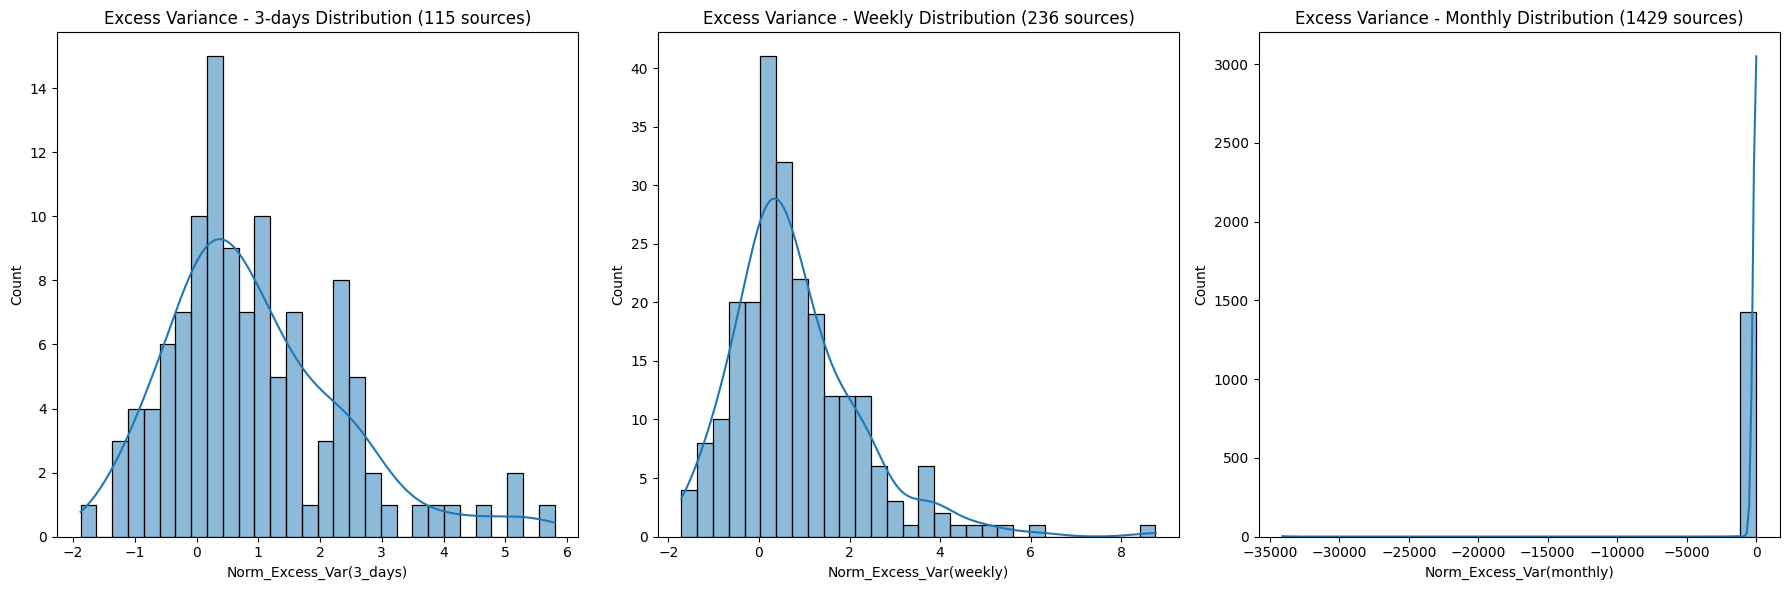

In [29]:
## Histograms

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(df_4lac_luana_dr3['Norm_Excess_Var(3_days)'], bins=30, kde=True, ax=axes[0])
axes[0].set_title(f"Excess Variance - 3-days Distribution ({len(df_4lac_luana_dr3['Norm_Excess_Var(3_days)'].dropna())} sources)")

sns.histplot(df_4lac_luana_dr3['Norm_Excess_Var(weekly)'], bins=30, kde=True, ax=axes[1])
axes[1].set_title(f"Excess Variance - Weekly Distribution ({len(df_4lac_luana_dr3['Norm_Excess_Var(weekly)'].dropna())} sources)")

sns.histplot(df_4lac_luana_dr3['Norm_Excess_Var(monthly)'], bins=30, kde=True, ax=axes[2])
axes[2].set_title(f"Excess Variance - Monthly Distribution ({len(df_4lac_luana_dr3['Norm_Excess_Var(monthly)'].dropna())} sources)")

plt.tight_layout()

plt.savefig('plots/df_4lac_luana_distributions.png')

plt.show()


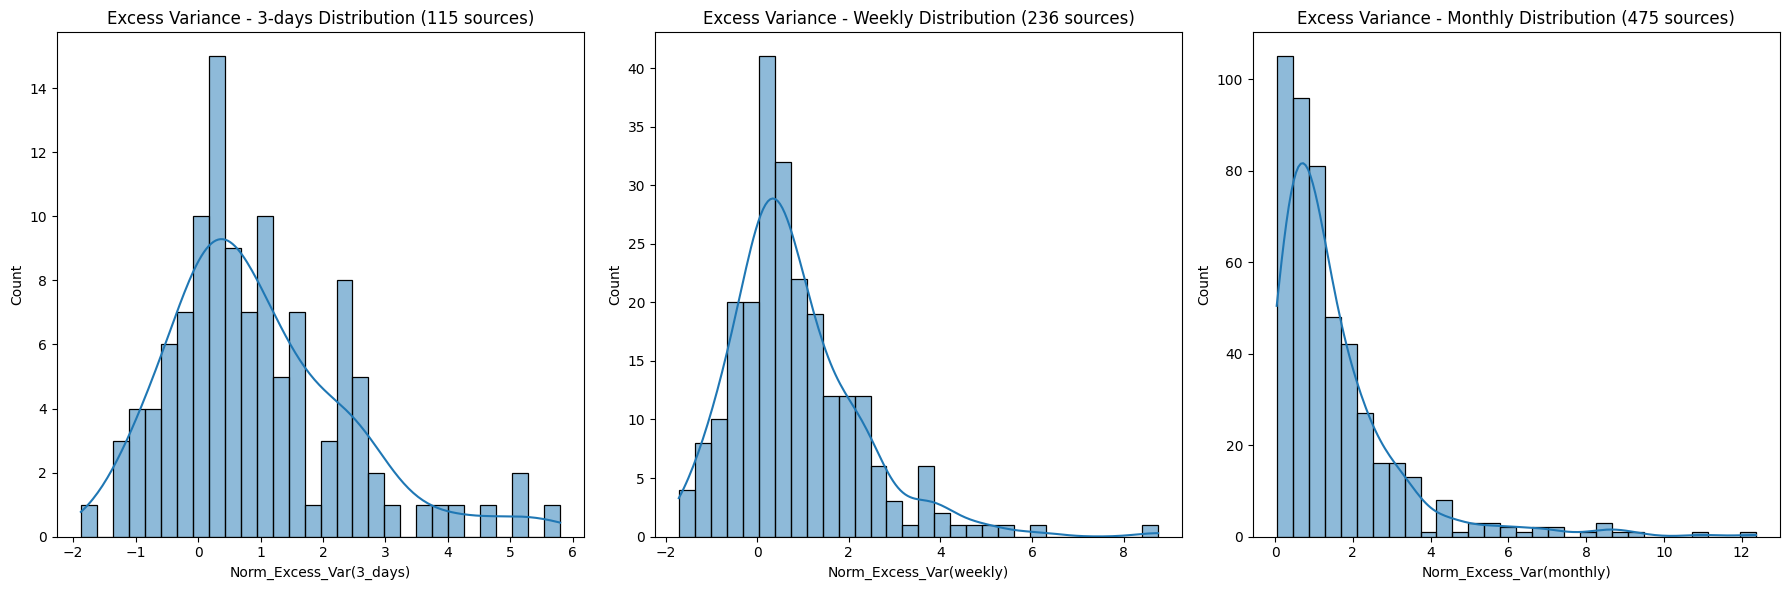

In [30]:
## Histograms

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'], bins=30, kde=True, ax=axes[0])
axes[0].set_title(f"Excess Variance - 3-days Distribution ({len(df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'].dropna())} sources)")

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(weekly)'], bins=30, kde=True, ax=axes[1])
axes[1].set_title(f"Excess Variance - Weekly Distribution ({len(df_filtered_4lac_luana_dr3['Norm_Excess_Var(weekly)'].dropna())} sources)")

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)'], bins=30, kde=True, ax=axes[2])
axes[2].set_title(f"Excess Variance - Monthly Distribution ({len(df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)'].dropna())} sources)")

plt.tight_layout()

plt.savefig('plots/df_filtered_distributions.png')

plt.show()

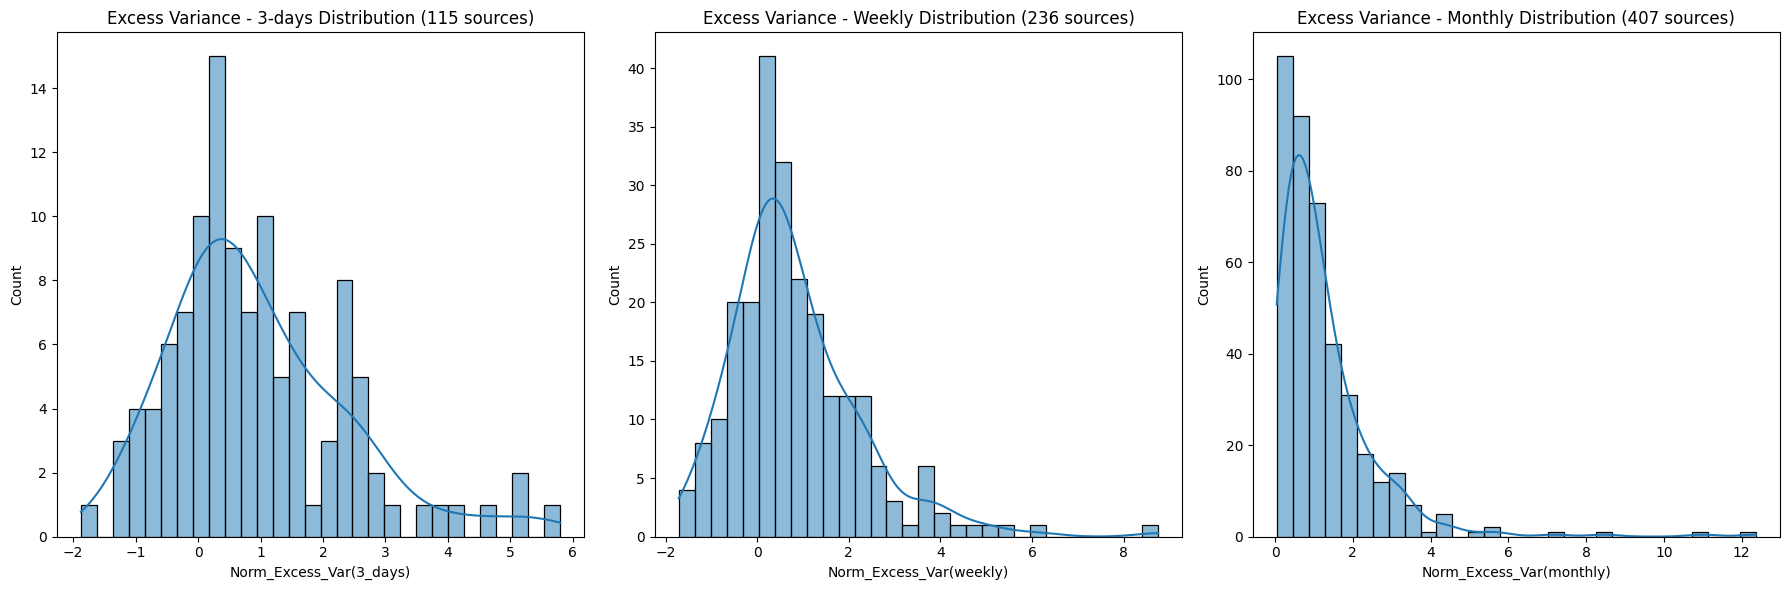

In [31]:
## Histograms

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'], bins=30, kde=True, ax=axes[0])
axes[0].set_title(f"Excess Variance - 3-days Distribution ({len(df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'].dropna())} sources)")

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(weekly)'], bins=30, kde=True, ax=axes[1])
axes[1].set_title(f"Excess Variance - Weekly Distribution ({len(df_filtered_4lac_luana_dr3['Norm_Excess_Var(weekly)'].dropna())} sources)")

sns.histplot(selected_sources_df['Norm_Excess_Var(monthly)'], bins=30, kde=True, ax=axes[2])
axes[2].set_title(f"Excess Variance - Monthly Distribution ({len(selected_sources_df['Norm_Excess_Var(monthly)'].dropna())} sources)")

plt.tight_layout()

plt.savefig('plots/selected_sources_df_distributions.png')

plt.show()

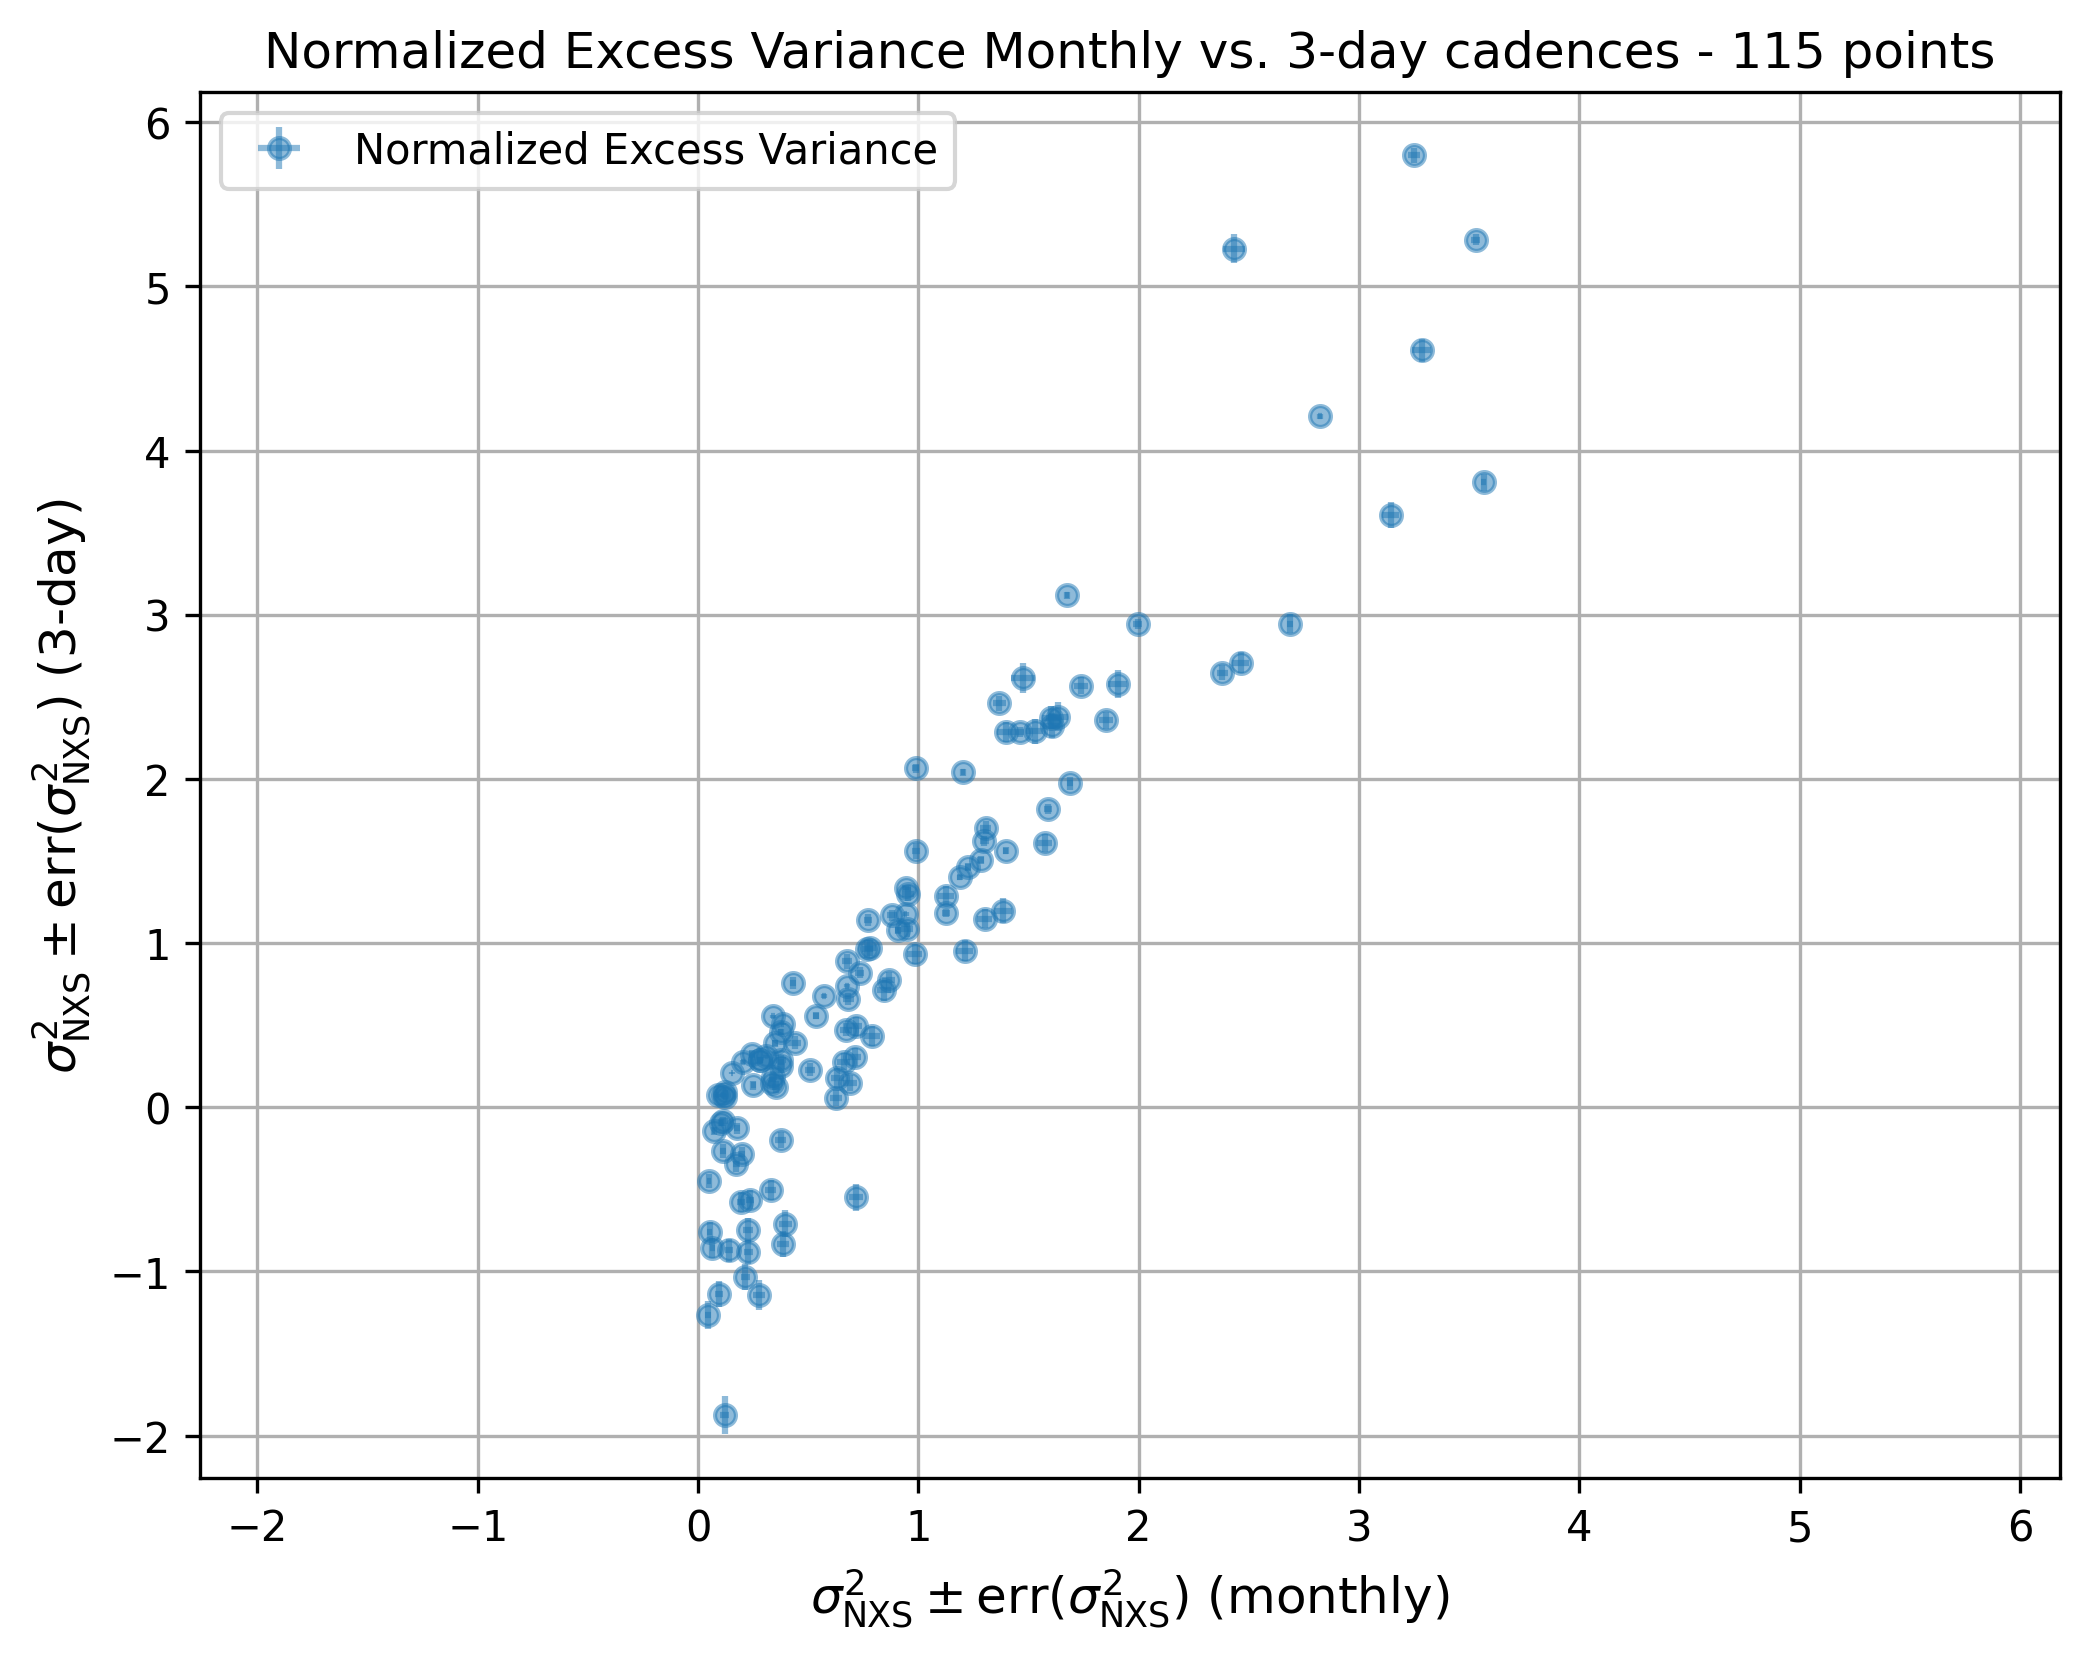

In [32]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

x = df_filtered_4lac_luana_dr3[df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'].notna()]

plt.errorbar(df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)'], df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'],
             xerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(monthly)'], yerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(3_days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)} points', fontsize=12)
plt.legend()

# plt.xscale('log')
# plt.yscale('log')

# plt.ylim(plt.xlim())
plt.xlim(plt.ylim())

plt.grid(True)
plt.savefig('plots/monthly_vs_3days.png',dpi=300)
plt.show()

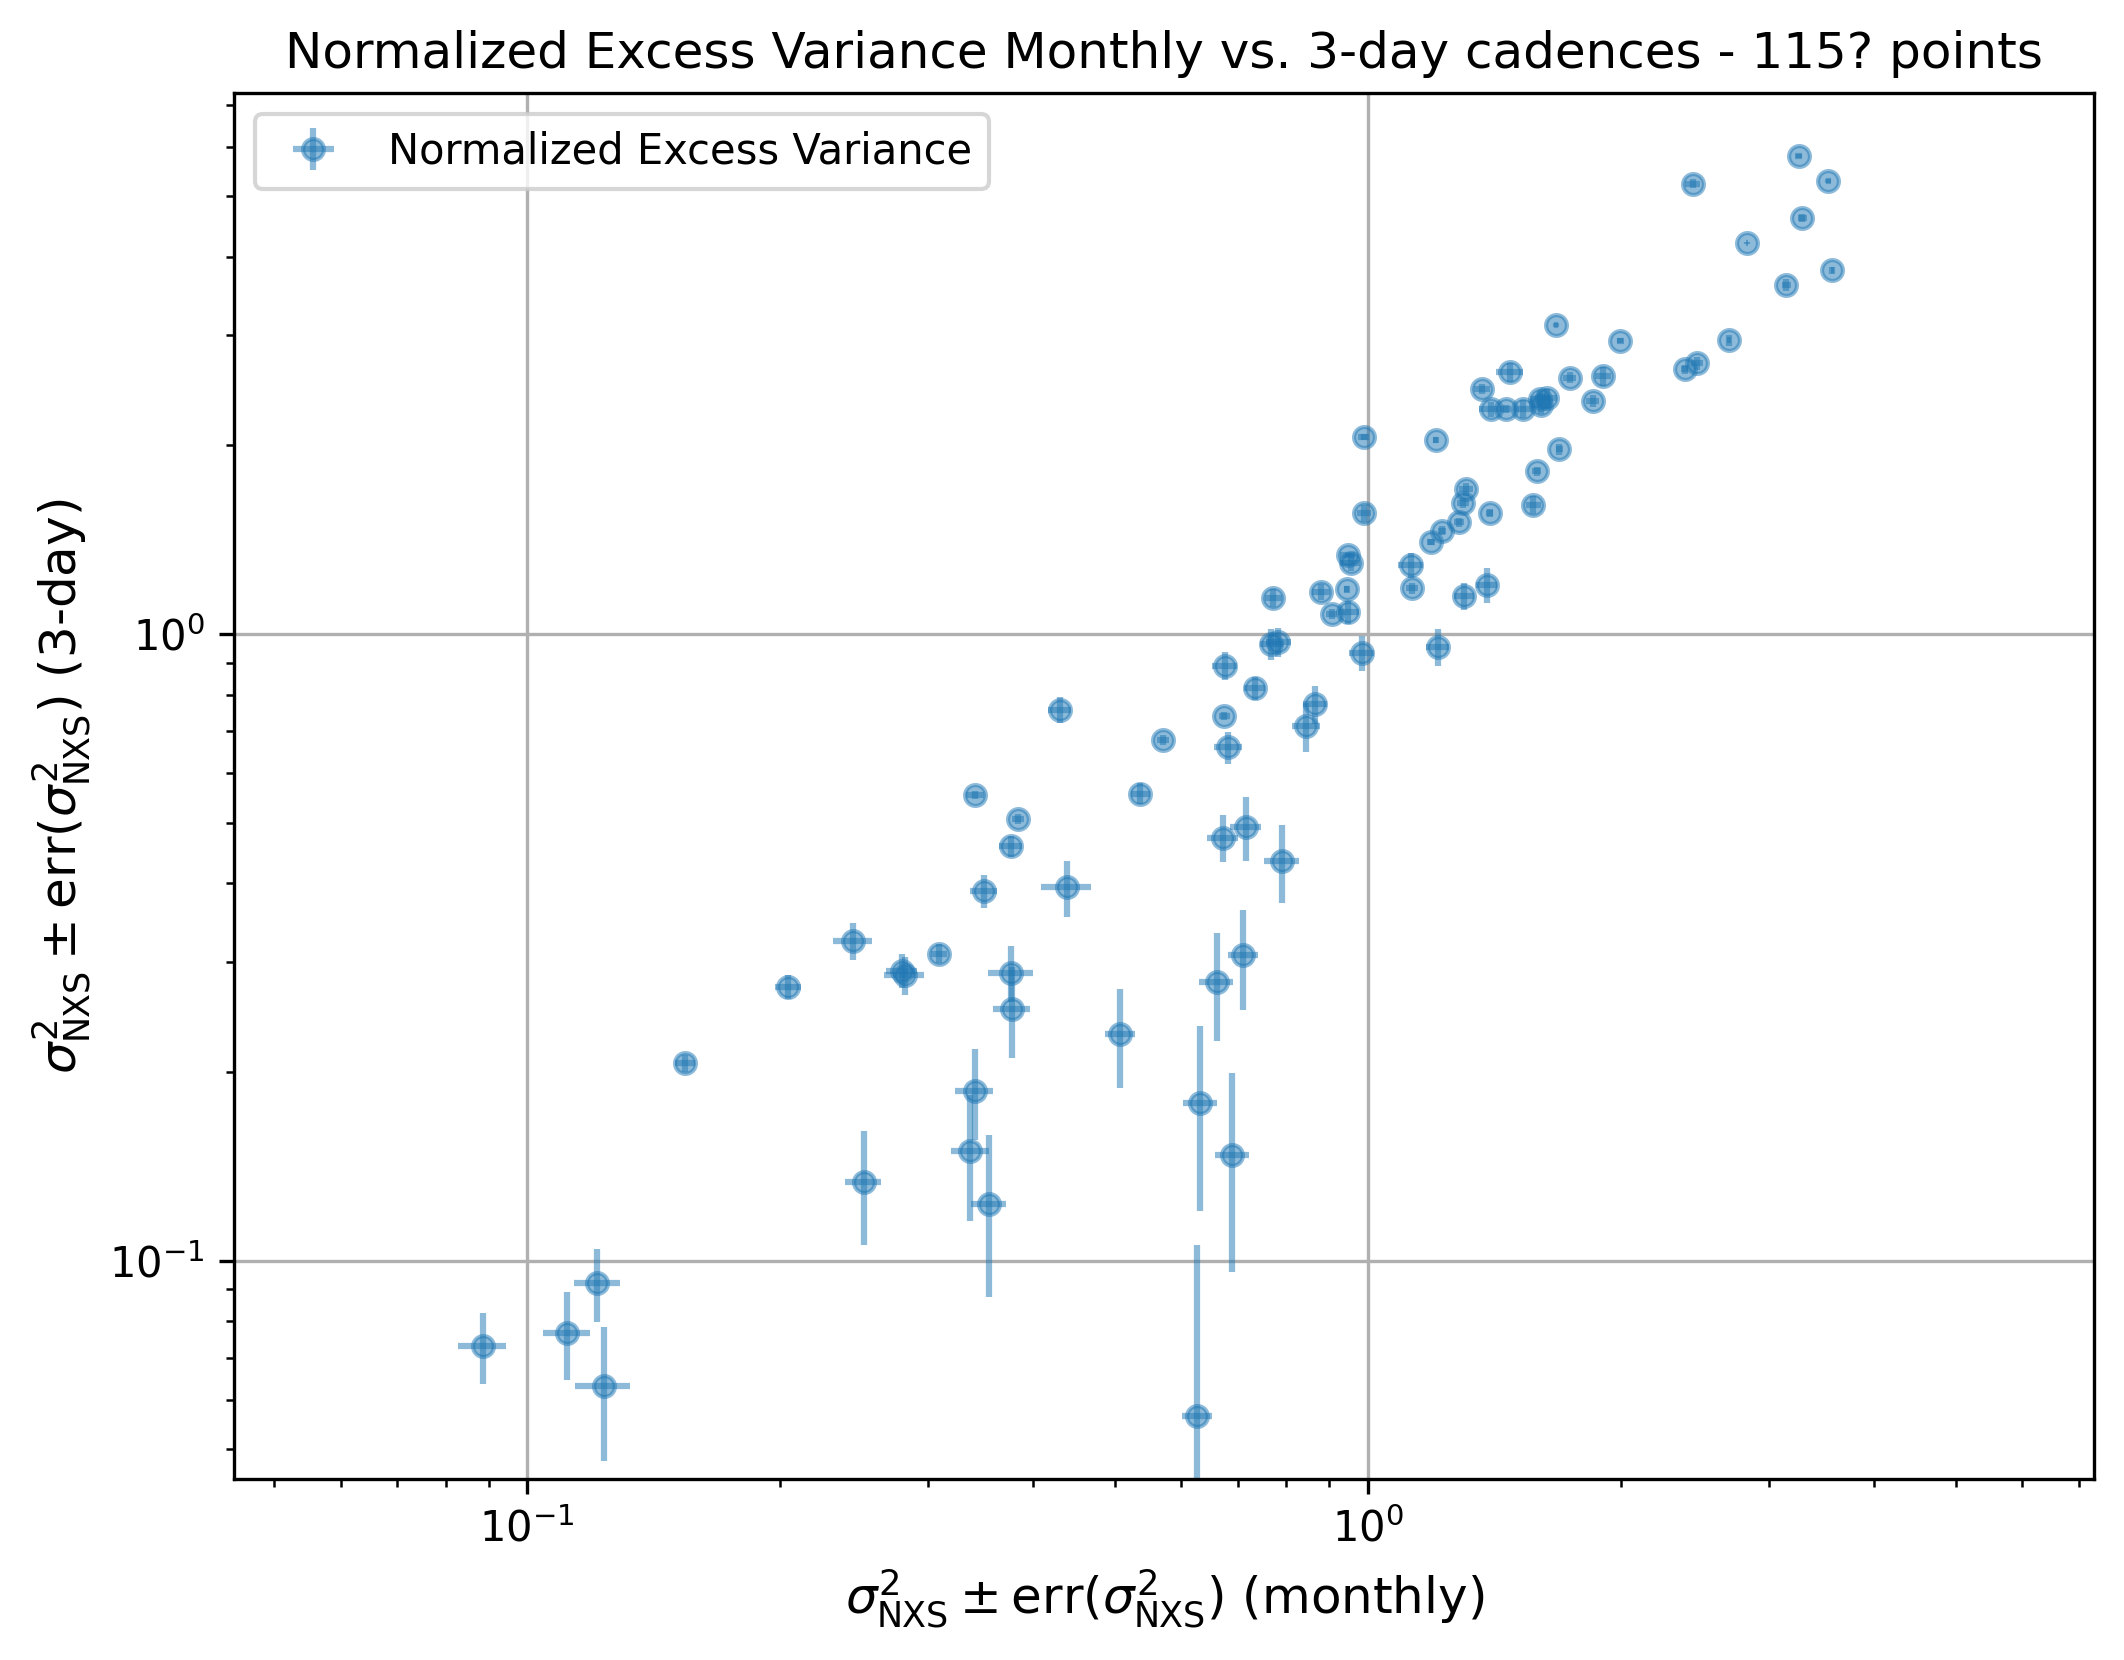

In [33]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

x = df_filtered_4lac_luana_dr3[df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'].notna()]
# x = x[x > 0]

plt.errorbar(df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)'], df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'],
             xerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(monthly)'], yerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(3_days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)}? points', fontsize=12)
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.xlim(plt.ylim())
# plt.ylim(plt.xlim())

plt.grid(True)
plt.savefig('plots/monthly_vs_3days_log.png',dpi=300)
plt.show()

In [34]:
## taking the log for the fit

x = df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)']
y = df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)']
x_err = df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(monthly)']
y_err = df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(3_days)']

In [35]:
## filter out non-positive values
valid_indices = (x > 0) & (y > 0)

x = x[valid_indices]
y = y[valid_indices]
x_err = x_err[valid_indices]
y_err = y_err[valid_indices]

In [36]:
len(x)

89

In [37]:
## Log transformation
log_x = np.log(x)
log_y = np.log(y)
log_x_err = x_err / x  # relative error in log scale
log_y_err = y_err / y  # relative error in log scale

Fitted parameter: a = 1.5732325396281668


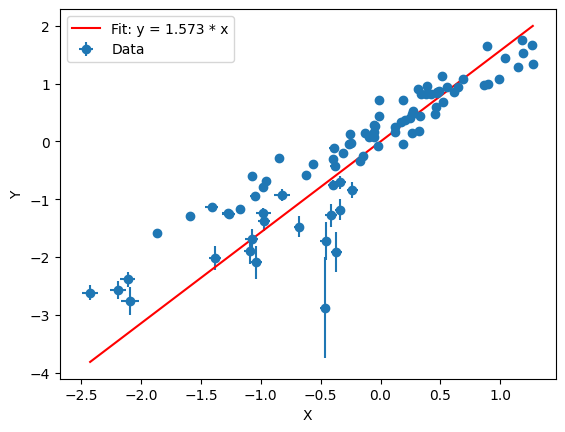

In [38]:
import scipy.odr as odr

def power_law_model(B, x):
    return B[0] * x

## create a model object
power_model = odr.Model(power_law_model)

x_data = log_x
y_data = log_y

x_err = log_x_err 
y_err = log_y_err

## prepare the data for ODR
data = odr.RealData(x_data, y_data, sx=x_err, sy=y_err)

# Set initial guess for the parameters [a, b]
initial_guess = [1.3, 1.0]

# Set up ODR with the model and data
odr_instance = odr.ODR(data, power_model, beta0=initial_guess)

# Run the ODR fitting
output = odr_instance.run()

# Extract the fitted parameters
a, b = output.beta
a = a+0.2
print(f"Fitted parameter: a = {a}")

# Plot the data and the fitted model
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit = power_law_model([a, b], x_fit)

plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='o', label='Data')
plt.plot(x_fit, y_fit, label=f'Fit: y = {a:.3f} * x', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [39]:
## sources in Lucas analysis regarding Imposed Energy cutoff [TeV]

# PKS 1510-089: J1512.8-0906
# 3C 66A: J0222.6+4302

In [40]:
## check main sources

# Mkn 421: J1104.4+3812
# Mkn 501: J1653.8+3945
# PKS 2155-304: J2158.8-3013
# 3C 273: J1229.0+0202

main_sources = ["J1104.4+3812", "J1653.8+3945", "J2158.8-3013", "J1229.0+0202", "J1512.8-0906", "J0222.6+4302"]

matched_sources = [source for source in main_sources if source in subset_bright_ratio['Source_Name'].values]

print("Matched sources:", matched_sources)

Matched sources: ['J1104.4+3812', 'J1653.8+3945', 'J2158.8-3013', 'J1229.0+0202', 'J1512.8-0906', 'J0222.6+4302']


In [41]:
# ## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

# plt.figure(figsize=(8,6), dpi=300)

# x = selected_table_monthly[selected_table_monthly['Norm_Excess_Var(3_days)'].notna()]

# plt.errorbar(selected_table_monthly['Norm_Excess_Var(monthly)'], selected_table_monthly['Norm_Excess_Var(3_days)'],
#              xerr=selected_table_monthly['Unc_Norm_Excess_Var(monthly)'], yerr=selected_table_monthly['Unc_Norm_Excess_Var(3_days)'],
#              fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
# plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)} sources', fontsize=12)
# plt.legend()

# # plt.xscale('log')
# # plt.yscale('log')

# # plt.ylim(plt.xlim())
# plt.xlim(plt.ylim())

# plt.grid(True)
# plt.savefig('plots/selected_monthly_vs_3days.png',dpi=300)
# plt.show()

In [42]:
# ## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

# plt.figure(figsize=(8,6), dpi=300)

# x = selected_table_monthly[selected_table_monthly['Norm_Excess_Var(3_days)'].notna()]
# # x = x[x > 0]

# plt.errorbar(selected_table_monthly['Norm_Excess_Var(monthly)'], selected_table_monthly['Norm_Excess_Var(3_days)'],
#              xerr=selected_table_monthly['Unc_Norm_Excess_Var(monthly)'], yerr=selected_table_monthly['Unc_Norm_Excess_Var(3_days)'],
#              fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
# plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)}? sources', fontsize=12)
# plt.legend()

# plt.xscale('log')
# plt.yscale('log')

# # plt.xlim(plt.ylim())
# # plt.ylim(plt.xlim())

# plt.xlim(1e-2,1e1)

# plt.grid(True)
# plt.savefig('plots/selected_monthly_vs_3days_log.png',dpi=300)
# plt.show()

In [43]:
# from scipy.optimize import curve_fit

# ## model y = a * x^b
# def model(x, a, b):
#     return a * x**b

# data = selected_table_monthly[selected_table_monthly['Norm_Excess_Var(3_days)'].notna()]
# x = data['Norm_Excess_Var(monthly)']
# y = data['Norm_Excess_Var(3_days)']
# xerr = data['Unc_Norm_Excess_Var(monthly)']
# yerr = data['Unc_Norm_Excess_Var(3_days)']

# ## fit with both a and b free
# popt_free, pcov_free = curve_fit(model, x, y, sigma=yerr, absolute_sigma=True)
# a_free, b_free = popt_free

# ## fit with b = 1 fixed
# def model_fixed(x, a):
#     return a * x

# popt_fixed, pcov_fixed = curve_fit(model_fixed, x, y, sigma=yerr, absolute_sigma=True)
# a_fixed = popt_fixed[0]

# ## create x-range for plotting the fits
# x_fit = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)
# y_fit_free = model(x_fit, a_free, b_free)
# y_fit_fixed = model_fixed(x_fit, a_fixed)

In [44]:
# ## square roots of the diagonal elements of the covariance matrices
# ## (pcov_free and pcov_fixed)

# ## a & b free
# a_free_err, b_free_err = np.sqrt(np.diag(pcov_free))
# print(f"Fit with a and b free:")
# print(f"  a = {a_free:.4e} ± {a_free_err:.4e}")
# print(f"  b = {b_free:.4f} ± {b_free_err:.4f}")

# ## a free & b=1
# a_fixed_err = np.sqrt(np.diag(pcov_fixed))[0]
# print(f"\nFit with b fixed (b=1):")
# print(f"  a = {a_fixed:.4e} ± {a_fixed_err:.4e}")

In [45]:
# plt.figure(figsize=(8, 6), dpi=300)
# plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

# plt.plot(x_fit, y_fit_free, label=f'Fit (free): $y = {a_free:.3f} * x^{{{b_free:.2f}}}$', color='red')
# plt.plot(x_fit, y_fit_fixed, label=f'Fit (b=1): $y = {a_fixed:.3f} * x^1$', color='blue', linestyle='--')

# plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
# plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)} sources', fontsize=12)

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1e-2, 1e1)
# plt.grid(True)
# plt.legend()
# plt.savefig('plots/selected_monthly_vs_3days_log_fit.png', dpi=300)
# plt.show()

In [46]:
## bootstrap - 80% / 90% of points many times

previous fitting way

In [47]:
## taking the log for the fit

x_previous = selected_sources_df['Norm_Excess_Var(monthly)']
y_previous = selected_sources_df['Norm_Excess_Var(3_days)']
x_err_previous = selected_sources_df['Unc_Norm_Excess_Var(monthly)']
y_err_previous = selected_sources_df['Unc_Norm_Excess_Var(3_days)']

In [48]:
## filter out non-positive values
valid_indices = (x_previous > 0) & (y_previous > 0)

x_previous = x_previous[valid_indices]
y_previous = y_previous[valid_indices]
x_err_previous = x_err_previous[valid_indices]
y_err_previous = y_err_previous[valid_indices]

In [49]:
len(x_previous)

89

In [50]:
## Log transformation
log_x = np.log(x_previous)
log_y = np.log(y_previous)
log_x_err = x_err_previous / x_previous  # relative error in log scale
log_y_err = y_err_previous / y_previous  # relative error in log scale

Fitted parameter: a = 1.3732325396281668 ± 0.03390491592957249
Fitted parameter: b = 1.0 ± 0.0


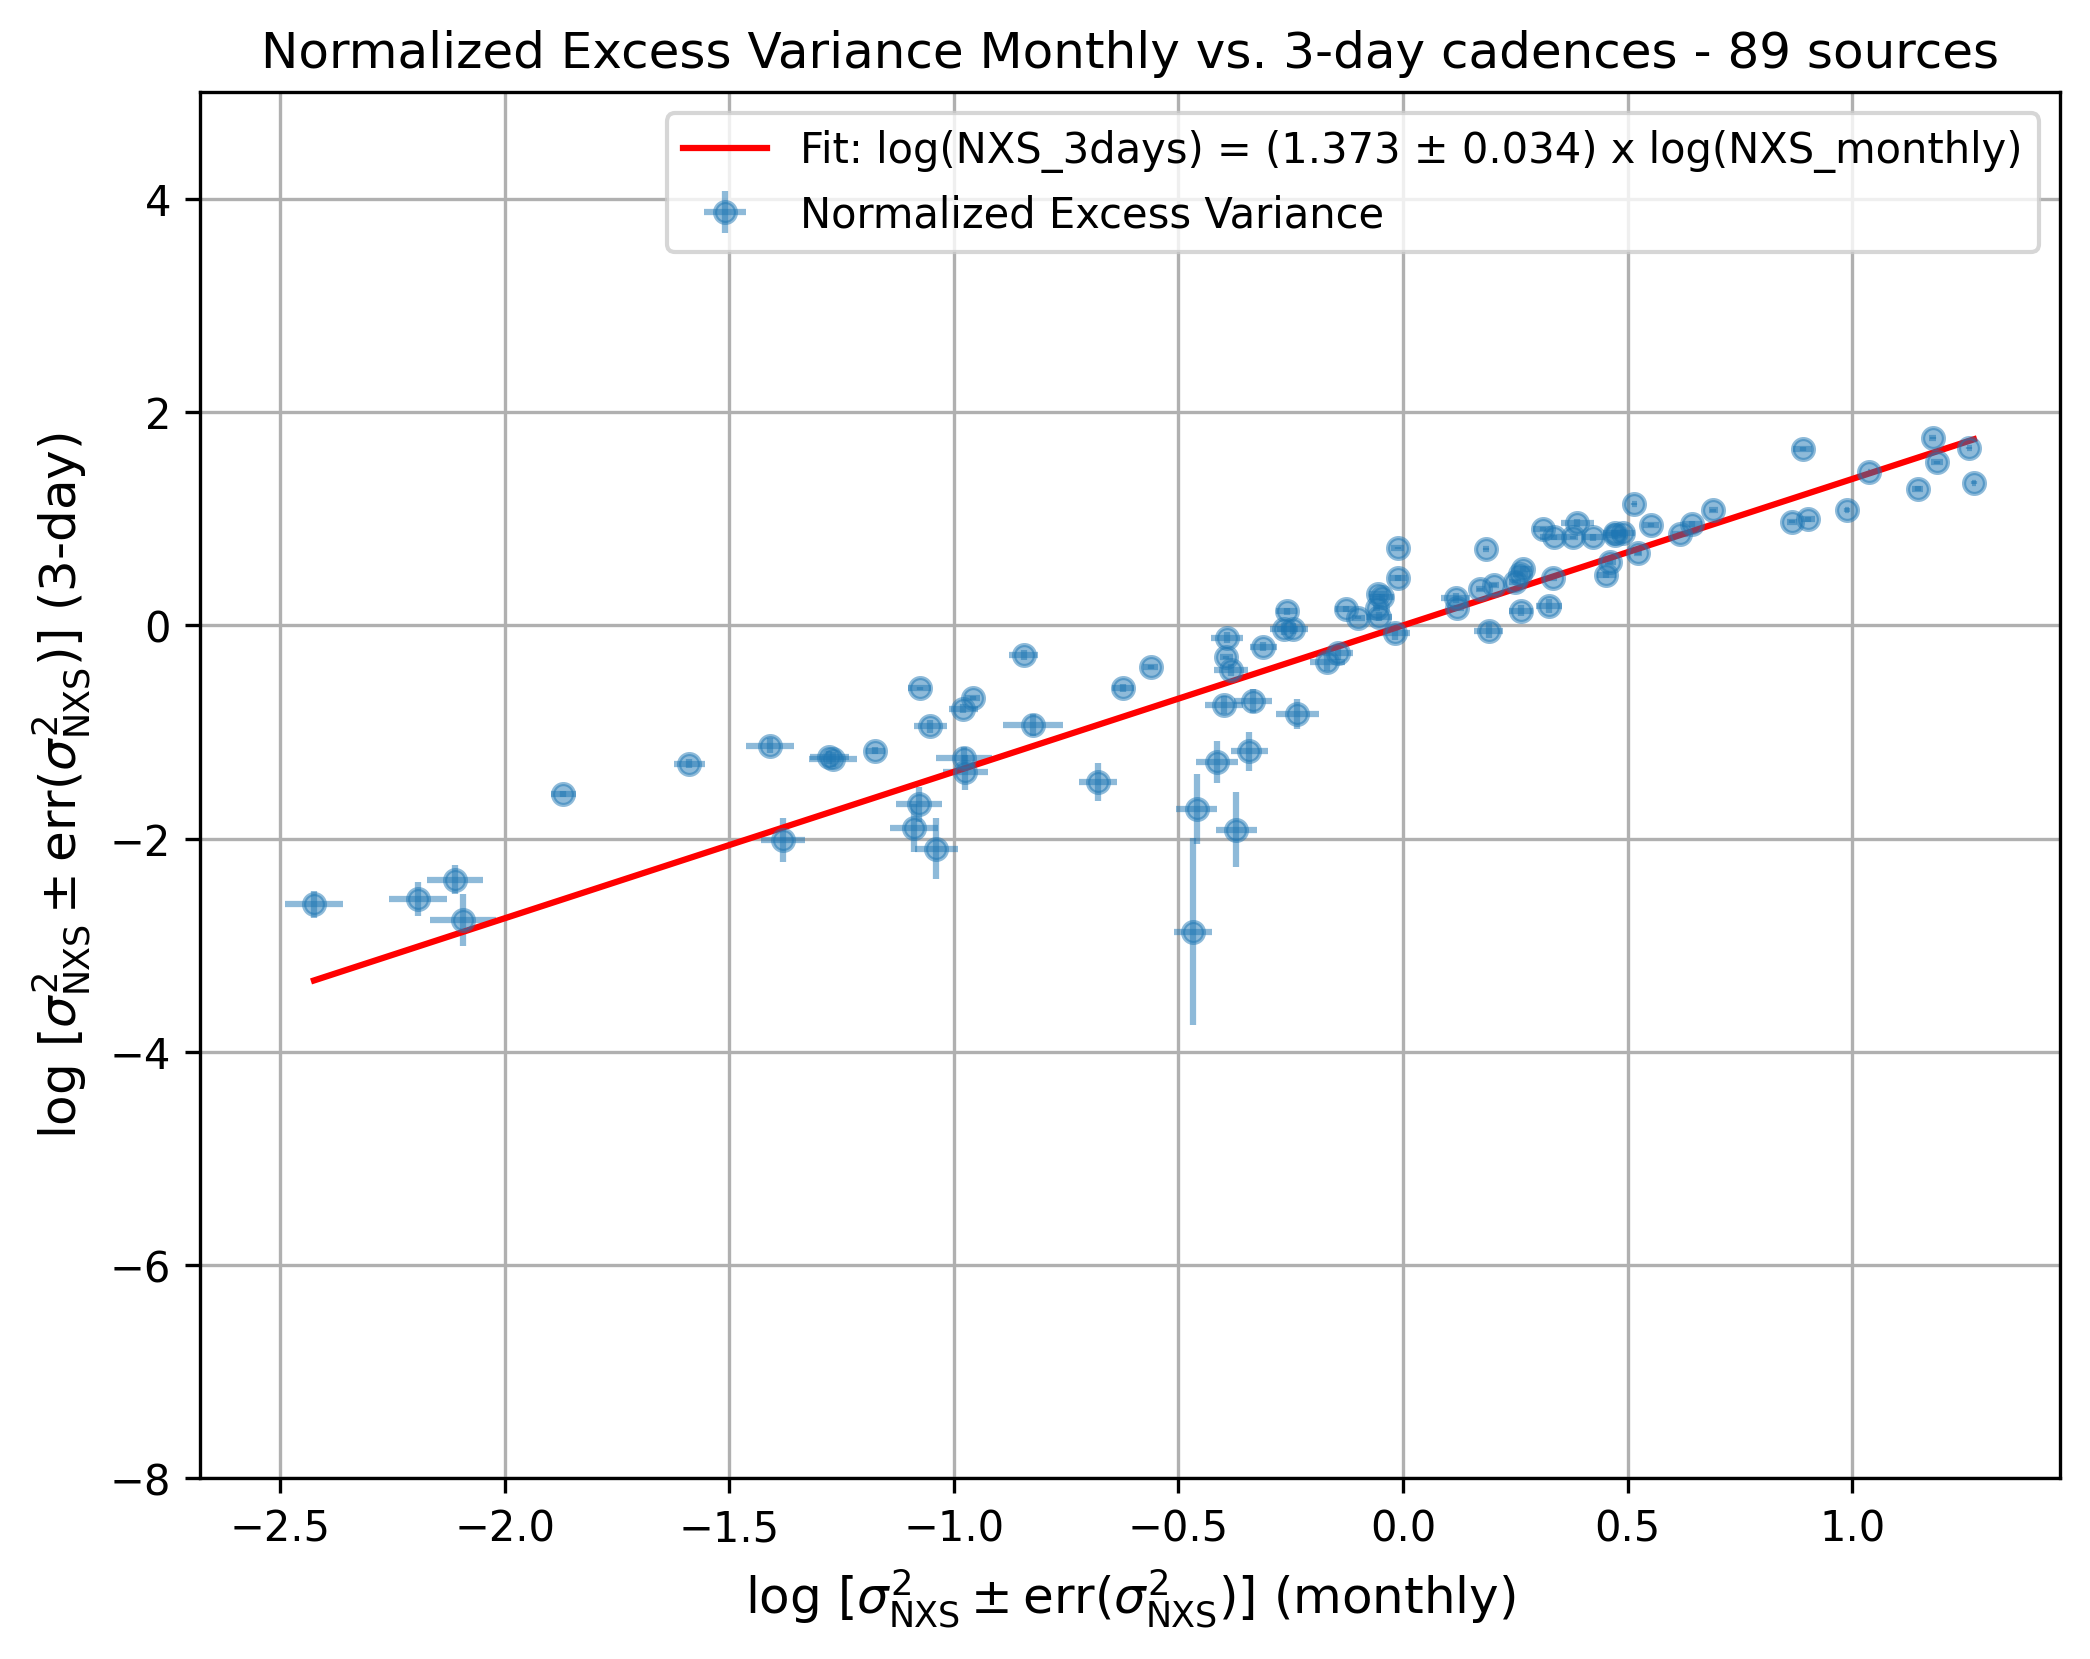

In [51]:
import scipy.odr as odr

def power_law_model(B, x):
    return B[0] * x

## create a model object
power_model = odr.Model(power_law_model)

x_data = log_x
y_data = log_y

x_err = log_x_err 
y_err = log_y_err

## prepare the data for ODR
data = odr.RealData(x_data, y_data, sx=x_err, sy=y_err)

## et initial guess for [a, b]
initial_guess = [1.3, 1.0]

## set up ODR with the model and data
odr_instance = odr.ODR(data, power_model, beta0=initial_guess)

## run the ODR fitting
output = odr_instance.run()

## extract the fitted parameters
a, b = output.beta
a_err, b_err = output.sd_beta

print(f"Fitted parameter: a = {a} ± {a_err}")
print(f"Fitted parameter: b = {b} ± {b_err}")

## plot the data and the fitted model
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit = power_law_model([a, b], x_fit)

plt.figure(figsize=(8,6), dpi=300)

plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err,
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')
plt.plot(x_fit, y_fit, label=f'Fit: log(NXS_3days) = ({a:.3f} ± {a_err:.3f}) x log(NXS_monthly)', color='red')

plt.xlabel('log [$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$] (monthly)', fontsize=12)
plt.ylabel('log [$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$] (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x_data)} sources', fontsize=12)
plt.legend()

# plt.xlim(plt.ylim())
plt.ylim(-8,5)

plt.grid(True)
# plt.savefig('plots/selected_monthly_vs_3days_log_fit.png',dpi=300)
plt.show()


In [52]:
df_4lac_luana_dr3

,Source_Name,SpectrumType,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Spectrum_Flux_Estimated,Bright_Ratio_x,Norm_Excess_Var(3_days),...,Bright_Ratio_y,Norm_Excess_Var(weekly),Unc_Norm_Excess_Var(weekly),Frac_Variability(weekly),Unc_Frac_Variability(weekly),Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.2+4741,PowerLaw,bcu,ISP,25.313953,0.675882,0.312850,1.993321e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J0001.2-0747,PowerLaw,bll,LSP,46.780693,0.406565,0.111870,9.825299e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.738318,-0.831176,0.204850,0.000000,0.100000
2,J0001.4-0010,PowerLaw,bll,LSP,9.272764,0.000000,10.000000,8.602307e-10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J0001.5+2113,LogParabola,fsrq,ISP,1910.935791,0.996138,0.213478,6.391699e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.553719,2.312904,0.130572,1.520823,0.042928
4,J0001.6-4156,PowerLaw,bcu,HSP,26.393343,0.490977,0.175782,1.599132e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,J2359.3+0215,LogParabola,bcu,LSP,16.065315,0.311971,0.625833,1.655760e-10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3810,J2359.3-2049,PowerLaw,bll,LSP,14.043210,0.177217,0.190973,3.021906e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3811,J2359.7-5041,LogParabola,bcu,LSP,7.732565,0.000000,10.000000,1.205902e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3812,J2359.9-3736,PowerLaw,bcu,LSP,8.143241,0.000000,10.000000,2.216054e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df_filtered_4lac_luana_dr3

,Source_Name,SpectrumType,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Spectrum_Flux_Estimated,Bright_Ratio_x,Norm_Excess_Var(3_days),...,Bright_Ratio_y,Norm_Excess_Var(weekly),Unc_Norm_Excess_Var(weekly),Frac_Variability(weekly),Unc_Frac_Variability(weekly),Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.2-0747,PowerLaw,bll,LSP,46.780693,0.406565,0.111870,9.825299e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J0001.5+2113,LogParabola,fsrq,ISP,1910.935791,0.996138,0.213478,6.391699e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.553719,2.312904,0.130572,1.520823,0.042928
2,J0003.3-1928,LogParabola,bcu,LSP,49.879936,0.591879,0.159972,3.715681e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J0004.3+4614,LogParabola,fsrq,LSP,139.036758,1.016224,0.234237,1.086787e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,J0004.4-4737,PowerLaw,fsrq,LSP,153.286484,0.823498,0.188146,1.070792e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,J2358.0-4601,PowerLaw,bcu,LSP,30.538687,0.477398,0.157409,5.184782e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1425,J2358.3-1021,LogParabola,fsrq,LSP,195.553940,0.668076,0.150551,2.164930e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1426,J2358.3+3830,PowerLaw,bll,NaN,42.173111,0.567347,0.164919,4.248420e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1427,J2359.0+3922,PowerLaw,fsrq,LSP,56.146664,0.779921,0.203910,7.005793e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
## add column in our final selected table

# selected_sources_df['Norm_Excess_Var_Extrapolated(3_days)'] = selected_sources_df['Norm_Excess_Var(monthly)']**a

In [55]:
table_4lac_luana_dr3 = Table.from_pandas(df_4lac_luana_dr3)
table_filtered_4lac_luana_dr3 = Table.from_pandas(df_filtered_4lac_luana_dr3) 
table_selected_monthly = Table.from_pandas(selected_sources_df)

In [56]:
table_selected_monthly

Source_Name,Bright_Ratio_x,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly),Bright_Ratio_y,Norm_Excess_Var(3_days),Unc_Norm_Excess_Var(3_days),Frac_Variability(3_days),Unc_Frac_Variability(3_days)
str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0001.5+2113,0.5537190082644629,2.3129040946772745,0.1305723539681703,1.52082349228215,0.04292817497585904,--,--,--,--,--
J0009.3+5030,0.09941520467836257,0.2010559569548613,0.032965010345735,0.4483926370435417,0.03675908971553194,--,--,--,--,--
J0011.4+0057,0.9183673469387755,1.1278537043479182,0.22652738313699072,1.062004568892205,0.10665085149929499,--,--,--,--,--
J0022.5+0608,0.09302325581395349,0.31619908564403554,0.037403575820476126,0.5623158237539074,0.03325851260131483,--,--,--,--,--
J0030.3-4224,0.19745222929936307,1.0020374343790135,0.06120842102062212,1.001018198825083,0.03057308103512193,--,--,--,--,--
J0030.6-0212,0.5537190082644629,0.6921069067245313,0.16555323447402984,0.8319296284689778,0.09949954227420764,--,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...
J2327.5+0939,0.5932203389830508,0.9601419046381099,0.1243895758324225,0.9798683098448026,0.0634725986046656,--,--,--,--,--
J2328.3-4036,0.46875,1.4378391931941477,0.11713470784519044,1.1990993258250744,0.04884278780016517,--,--,--,--,--


In [57]:
## save table

table_selected_monthly.write('./resulting_catalogs/selected_sources_monthly.fits', format='fits', overwrite=True)
table_selected_monthly.write('./resulting_catalogs/selected_sources_monthly.ecsv', format='ascii.ecsv', overwrite=True)

table_4lac_luana_dr3.write('./resulting_catalogs/df_4lac_luana_dr3.fits', format='fits', overwrite=True)
table_4lac_luana_dr3.write('./resulting_catalogs/df_4lac_luana_dr3.ecsv', format='ascii.ecsv', overwrite=True)

table_filtered_4lac_luana_dr3.write('./resulting_catalogs/df_filtered_4lac_luana_dr3.fits', format='fits', overwrite=True)
table_filtered_4lac_luana_dr3.write('./resulting_catalogs/df_filtered_4lac_luana_dr3.ecsv', format='ascii.ecsv', overwrite=True)